In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

from re import match
from copy import deepcopy

import gamspec as gt
import gamspec.utils as ut

pipenet = gt.default

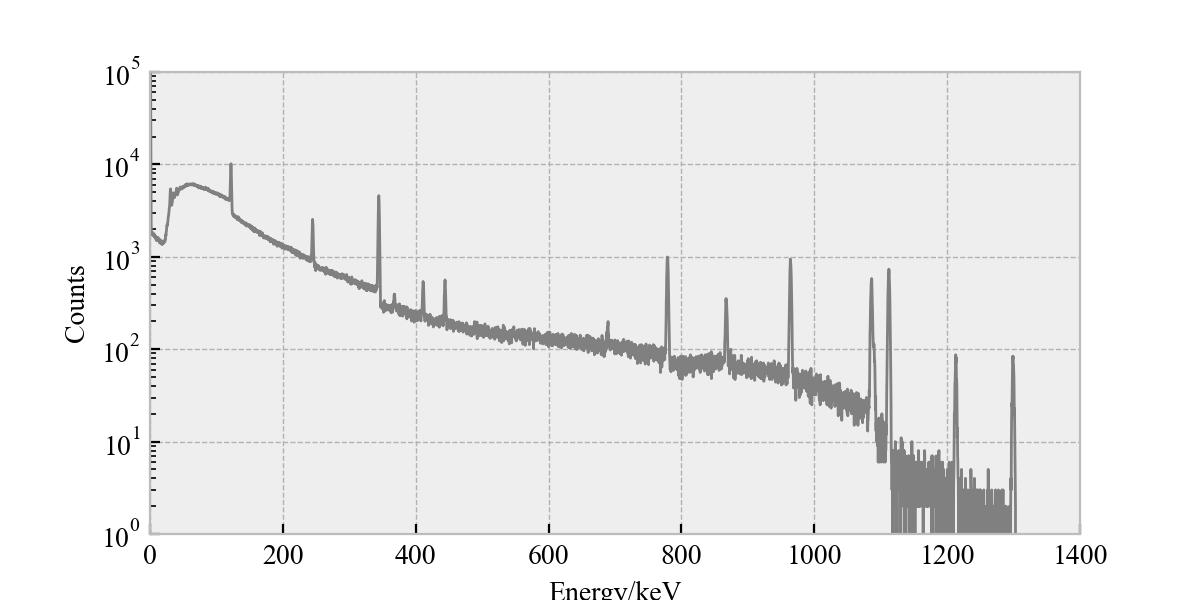

In [2]:
%matplotlib widget
plt.close()
plt.figure(figsize=(6, 3))

spec = gt.Spectrum.from_MCNP(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱\test spectra\Eu152_test_new_10000000.out')
spec.plot('gray')

plt.yscale('log')
plt.ylim(1, 1e5)
plt.xlim(0, 1400)
plt.show()

In [3]:
folder = pathlib.Path(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱\test spectra')
files = folder.glob('*.out')

combined_results = []
origins = {}
analyzeds = {}
for file in files:
    output = pathlib.Path().cwd() / (file.stem +'.xlsx')

    if output.exists():
        df = pd.read_excel(str(output))
        spectrum = gt.Spectrum.from_MCNP(str(file))
        analyzed = gt.Spectrum.from_xml(folder / (file.stem +'.xml'))
    else:
        spectrum = gt.Spectrum.from_MCNP(str(file))
        analyzed = pipenet([spectrum])[4][0]
        analyzed.export_to_xml(folder / (file.stem +'.xml'))
        df = analyzed.export_to_pandas()
        df.to_excel(str(output))

    NPS = int(match(r'Eu152_test_new_(\d+)', file.stem).group(1))
    df['NPS'] = NPS
    combined_results.append(df)
    origins[NPS] = spectrum
    analyzeds[NPS] = analyzed

In [65]:
from gamspec import *


wavelet = TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)
fsmooth = Flow(wavelet, 0, 0, 1, 0)

# branch flow for peak searching
savit = SavitzkySmoother(2, 3)
convol = SecondConvolutionPeakSearcher(10)
# convol._min_height_ratio = 3
# convol._min_area_ratio = 3
# convol._min_height = 20
# convol._min_area = 100
searcher = CovarianceSearcher(5, 3, 'inverse')
searcher._merge_mode = "Old"
# searcher._min_height_ratio = 1
# searcher._min_area_ratio = 1
# searcher._min_height = 0
# searcher._min_area = 0
fpeak = Flow([savit, convol], 0, 0, 1, 1)

# merge banch flows
def combine(spec1, spec2):
    combined = spec1.copy()
    combined.regions = deepcopy(spec2.regions)
    return combined
comb = Combinor(2, func=combine)
fcomb = Flow(comb, 1, [0, 1], 2, 0)

# flow for adaptive SNIP stripper
strp = OtherOperator.AdaptiveSNIPStripper(baseline=False, high_order=False)
fstrip = Flow(strp, 2, 0, 3, 0)

# flow for peak fitting
fit = RegionPeakFitter(3, equal_width=True, baseline=False)
ffit = Flow(fit, 3, 0, 4, 0)

default = PipeNet([fpeak, fsmooth, fcomb, fstrip, ffit])


In [66]:
# searcher = CovarianceSearcher(5, 3, 'inverse')

searched = searcher(convol(origins[1E7].slice((1000, 1200))))
fitted = fit(strp(searched))

Fitting Region: 275~324, NPeaks=2, time=Mon Mar 25 17:26:34 2024
Finish Fitting Region: time=Mon Mar 25 17:26:34 2024
Fitting Region: 367~401, NPeaks=1, time=Mon Mar 25 17:26:34 2024
Finish Fitting Region: time=Mon Mar 25 17:26:35 2024


In [67]:
fitted.export_to_pandas()

,left,right,energy,location,height,stderr,area,sig_area2,fitness
0,275,324,1085.926336,293,540.938318,4.059088,5503.843803,88.063329,0.995168
1,275,324,1090.030809,307,81.729890,4.059088,831.570866,37.653463,0.995168
2,367,401,1112.312234,383,707.332364,4.248667,7532.968413,106.796918,0.997006


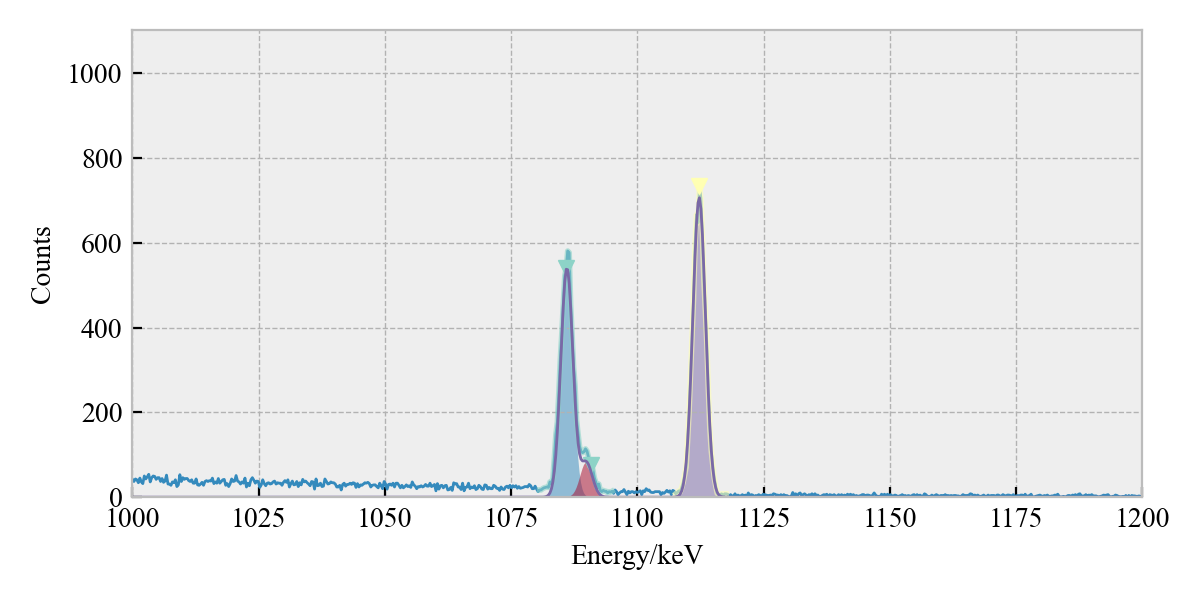

In [68]:
%matplotlib widget

plt.close()
plt.figure(figsize=(6, 3))

searched.plot()
searched.plot_regions()
fitted.plot_peaks()


plt.xlim((1000, 1200))
plt.tight_layout() 
plt.show()


In [4]:
analyszed = gt.default([origins[1E7]])

GAMUT: Start running PipeNet
|Execute: Node 0|[0] >> SavitzkySmoother[O2W7]>>SecondConvolutionSearcher[F10] >> Node 1|[1]
|Execute: Node 0|[0] >> TIWaveletSmoother[O3MqTv] >> Node 1|[0]
|Execute: Node 1|[0, 1] >> Combinor >> Node 2|[0]
|Execute: Node 2|[0] >> AdaptiveSNIPStripper >> Node 3|[0]
|Execute: Node 3|[0] >> RegionPeakFitter >> Node 4|[0]
Fitting Region: 34~51, NPeaks=1, time=Mon Mar 25 16:05:13 2024
Finish Fitting Region: time=Mon Mar 25 16:05:13 2024
Fitting Region: 66~199, NPeaks=5, time=Mon Mar 25 16:05:13 2024
Finish Fitting Region: time=Mon Mar 25 16:05:15 2024
Fitting Region: 277~318, NPeaks=1, time=Mon Mar 25 16:05:15 2024
Finish Fitting Region: time=Mon Mar 25 16:05:16 2024
Fitting Region: 341~392, NPeaks=1, time=Mon Mar 25 16:05:16 2024
Finish Fitting Region: time=Mon Mar 25 16:05:16 2024
Fitting Region: 406~451, NPeaks=1, time=Mon Mar 25 16:05:16 2024
Finish Fitting Region: time=Mon Mar 25 16:05:17 2024
Fitting Region: 820~848, NPeaks=1, time=Mon Mar 25 16:05:17 202

In [5]:
analyszed[4][0].export_to_pandas()

,left,right,energy,location,height,stderr,area,sig_area2,fitness
0,34,51,11.140736,38,512.228517,5.512490,7077.852087,8175.336546,0.859615
1,66,199,30.783572,105,2130.393638,2.691049,14370.483023,153.323400,0.896265
2,66,199,35.181221,120,752.722985,3.251877,6135.629934,165.026334,0.896265
3,66,199,39.578871,135,775.872683,3.634640,7068.736180,194.958805,0.896265
4,66,199,45.149227,154,298.194080,8.047083,6014.886131,485.533734,0.896265
5,66,199,54.530880,186,167.062657,10.253548,4293.816782,1087.124743,0.896265
6,277,318,84.141722,287,143.631745,24.159484,8698.172607,42678.174872,0.082990
7,341,392,112.873034,385,105.337526,57.648262,15221.563651,929821.355007,0.016322
8,406,451,121.961510,416,6901.337990,2.419194,41849.857651,235.115223,0.995669
9,820,848,244.802526,835,1662.288247,2.798399,11660.195841,122.651484,0.992719


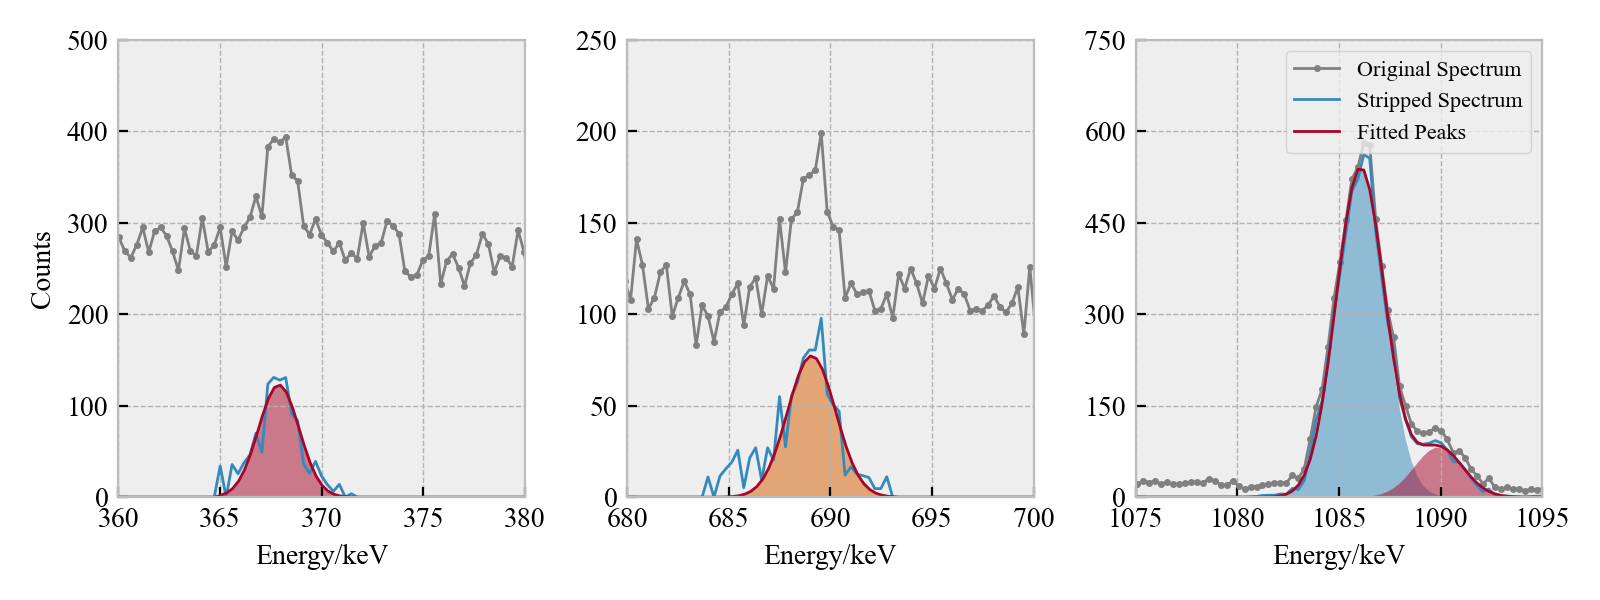

In [81]:
%matplotlib widget

plt.close()
plt.figure(figsize=(8, 3))

plt.rcParams['legend.fontsize'] = 8

baseline = analyszed[2][0] - analyszed[3][0]

plt.subplot(131)
origins[10000000].plot('.-', color='gray')
# (analyzeds[10000000]+baseline).plot_peaks(baseline=baseline, plot_baseline=False, plot_fitted=True)
analyszed[3][0].plot()
analyzeds[10000000].plot_peaks(plot_baseline=False, plot_fitted=True)
plt.xlim(360, 380)
plt.ylim(0, 500)
handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles, ['Original Spectrum', 'Stripped Spectrum', 'Fitted Peaks'])

plt.subplot(132)
origins[10000000].plot('.-', color='gray')
# (analyzeds[10000000]+baseline).plot_peaks(baseline=baseline, plot_baseline=False, plot_fitted=True)
analyszed[3][0].plot()
analyzeds[10000000].plot_peaks(plot_baseline=False, plot_fitted=True)

plt.xlim(680, 700)
plt.ylim(0, 250)
plt.gca().set_ylabel('')
handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles, ['Original Spectrum', 'Stripped Spectrum', 'Fitted Peaks'])

plt.subplot(133)
origins[10000000].plot('.-', color='gray')
analyszed[3][0].plot()
fitted.plot_peaks(plot_baseline=False, plot_fitted=True)
# (analyzeds[10000000]+baseline).plot_peaks(baseline=baseline, plot_baseline=False, plot_fitted=True)
# analyzeds[10000000].plot_peaks(plot_baseline=False, plot_fitted=True)

plt.xlim(1075, 1095)
plt.ylim(0, 750)
plt.yticks([150*i for i in range(6)])
plt.gca().set_ylabel('')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Original Spectrum', 'Stripped Spectrum', 'Fitted Peaks'])

plt.tight_layout() 
plt.show()

In [7]:
results = pd.concat(combined_results)
results

,Unnamed: 0,left,right,energy,location,height,stderr,area,sig_area2,fitness,NPS
0,0,8,36,6.156733,21,404.060246,9.942457,10070.006906,3345.835414,0.288207,10000000
1,1,66,199,30.783572,105,2176.375309,2.914320,15898.676171,153.300368,0.900872,10000000
2,2,66,199,35.181221,120,878.691503,2.858617,6296.254288,132.264196,0.900872,10000000
3,3,66,199,39.578871,135,756.866937,3.781347,7173.912056,214.055261,0.900872,10000000
4,4,66,199,45.149227,154,398.302082,4.330821,4323.871600,185.083683,0.900872,10000000
...,...,...,...,...,...,...,...,...,...,...,...
14,14,3271,3309,964.258026,3289,527.196312,3.989372,5271.895815,83.434141,0.996262,6000000
15,15,3686,3738,1086.219512,3705,322.374547,4.432814,3582.037822,67.861429,0.960064,6000000
16,16,3777,3811,1112.312234,3794,428.084493,4.184466,4490.135969,80.461181,0.993651,6000000
17,17,4125,4157,1213.165002,4138,43.796906,4.189966,459.985160,29.780794,0.991463,6000000


In [8]:
energies = np.array([40.12, 45.40, 121.78, 244.70, 344.28, 367.79, 411.11, 443.98, 688.68, 778.90, 867.39, 964.13, 1085.91, 1089.70, 1112.12, 1212.95, 1299.12])
percentages = np.array([29.119E-2, 7.304E-2, 14.016E-2, 3.697E-2, 13.128E-2, 0.410E-2, 1.101E-2, 1.372E-2, 0.412E-2, 6.396E-2, 2.048E-2, 7.077E-2, 4.896E-2, 0.844E-2, 6.687E-2, 0.690E-2, 0.802E-2])

filter = lambda x: True if ut.energy_in_group(x['energy'], energies) is not None else False
filtered_results = results[results.apply(filter, axis=1)]
filtered_results

,Unnamed: 0,left,right,energy,location,height,stderr,area,sig_area2,fitness,NPS
3,3,66,199,39.578871,135,756.866937,3.781347,7173.912056,214.055261,0.900872,10000000
4,4,66,199,45.149227,154,398.302082,4.330821,4323.871600,185.083683,0.900872,10000000
8,8,406,451,121.961510,416,6903.395979,2.425466,41970.865147,235.902648,0.995968,10000000
9,9,820,848,244.802526,835,1670.148162,2.801177,11726.961318,122.426918,0.993747,10000000
10,10,1157,1201,344.482587,1175,4220.616752,2.928734,30984.592255,189.476370,0.998895,10000000
...,...,...,...,...,...,...,...,...,...,...,...
14,14,3271,3309,964.258026,3289,527.196312,3.989372,5271.895815,83.434141,0.996262,6000000
15,15,3686,3738,1086.219512,3705,322.374547,4.432814,3582.037822,67.861429,0.960064,6000000
16,16,3777,3811,1112.312234,3794,428.084493,4.184466,4490.135969,80.461181,0.993651,6000000
17,17,4125,4157,1213.165002,4138,43.796906,4.189966,459.985160,29.780794,0.991463,6000000


In [9]:
extended_results = deepcopy(filtered_results)
extended_results['percentage'] = filtered_results.apply(lambda x: percentages[ut.energy_in_group(x['energy'], energies)], axis=1)
extended_results['relative_area'] = filtered_results['area'] / filtered_results['NPS']

extended_results

,Unnamed: 0,left,right,energy,location,height,stderr,area,sig_area2,fitness,NPS,percentage,relative_area
3,3,66,199,39.578871,135,756.866937,3.781347,7173.912056,214.055261,0.900872,10000000,0.29119,0.000717
4,4,66,199,45.149227,154,398.302082,4.330821,4323.871600,185.083683,0.900872,10000000,0.07304,0.000432
8,8,406,451,121.961510,416,6903.395979,2.425466,41970.865147,235.902648,0.995968,10000000,0.14016,0.004197
9,9,820,848,244.802526,835,1670.148162,2.801177,11726.961318,122.426918,0.993747,10000000,0.03697,0.001173
10,10,1157,1201,344.482587,1175,4220.616752,2.928734,30984.592255,189.476370,0.998895,10000000,0.13128,0.003098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,14,3271,3309,964.258026,3289,527.196312,3.989372,5271.895815,83.434141,0.996262,6000000,0.07077,0.000879
15,15,3686,3738,1086.219512,3705,322.374547,4.432814,3582.037822,67.861429,0.960064,6000000,0.04896,0.000597
16,16,3777,3811,1112.312234,3794,428.084493,4.184466,4490.135969,80.461181,0.993651,6000000,0.06687,0.000748
17,17,4125,4157,1213.165002,4138,43.796906,4.189966,459.985160,29.780794,0.991463,6000000,0.00690,0.000077


In [10]:
grouped_results = extended_results.groupby('NPS')
grouped_results.groups.keys()

dict_keys([6000000, 10000000, 20000000, 40000000])

In [11]:
res6E6, res1E7, res2E7, res4E7 = [grouped_results.get_group(NPS) for NPS in grouped_results.groups.keys()]
combined_results_1 = pd.merge(res6E6, res1E7, on='energy', suffixes=('_6E6', '_1E7'))
combined_results_2 = pd.merge(res2E7, res4E7, on='energy', suffixes=('_2E7', '_4E7'))
combined_results = pd.merge(combined_results_1, combined_results_2, on='energy')
combined_results


,Unnamed: 0_6E6,left_6E6,right_6E6,energy,location_6E6,height_6E6,stderr_6E6,area_6E6,sig_area2_6E6,fitness_6E6,...,right_4E7,location_4E7,height_4E7,stderr_4E7,area_4E7,sig_area2_4E7,fitness_4E7,NPS_4E7,percentage_4E7,relative_area_4E7
0,5,405,450,121.961510,416,4174.866733,2.449612,25634.798185,181.870371,0.993728,...,503,416,27457.407456,2.387705,164335.025323,434.779475,0.998099,40000000,0.14016,0.004108
1,6,821,848,244.802526,835,1017.545584,2.835097,7231.221350,97.359684,0.990884,...,853,835,6470.495536,2.716056,44052.055109,242.370449,0.998629,40000000,0.03697,0.001101
2,7,1163,1201,344.482587,1175,2546.596021,2.917297,18622.186399,157.920062,0.998884,...,1190,1175,16869.226634,2.918356,123402.321282,398.793811,0.999745,40000000,0.13128,0.003085
3,8,1246,1266,367.936719,1255,81.451948,3.185005,650.281605,41.536051,0.898651,...,1270,1255,500.175058,3.302805,4140.901811,82.412452,0.929907,40000000,0.00410,0.000104
4,9,1391,1413,411.326864,1403,191.875951,3.072719,1477.860202,52.465438,0.975425,...,1417,1403,1246.032261,3.182165,9938.982394,122.840240,0.994113,40000000,0.01101,0.000248
5,10,1505,1528,444.162648,1515,208.786177,3.353637,1755.123554,60.871608,0.970298,...,1529,1515,1394.574091,3.252982,11371.379273,139.950682,0.993248,40000000,0.01372,0.000284
6,12,2642,2674,778.970383,2657,562.287767,3.860863,5441.679525,88.956750,0.997145,...,2674,2657,3838.154143,3.720161,35791.024625,222.671865,0.999566,40000000,0.06396,0.000895
7,13,2947,2972,867.509731,2959,175.424981,3.968433,1745.019986,64.582757,0.973645,...,2979,2959,1098.608945,3.833576,10556.918537,116.357285,0.994516,40000000,0.02048,0.000264
8,14,3271,3309,964.258026,3289,527.196312,3.989372,5271.895815,83.434141,0.996262,...,3306,3289,3525.472039,3.928457,34715.960377,213.617203,0.999439,40000000,0.07077,0.000868
9,15,3686,3738,1086.219512,3705,322.374547,4.432814,3582.037822,67.861429,0.960064,...,3736,3705,2090.165424,4.346436,22772.141365,170.223244,0.970535,40000000,0.04896,0.000569


In [12]:
simplied_results = combined_results[['energy', 'relative_area_6E6', 'relative_area_1E7', 'relative_area_2E7', 'relative_area_4E7']]
simplied_results

,energy,relative_area_6E6,relative_area_1E7,relative_area_2E7,relative_area_4E7
0,121.961510,0.004272,0.004197,0.004223,0.004108
1,244.802526,0.001205,0.001173,0.001127,0.001101
2,344.482587,0.003104,0.003098,0.003111,0.003085
3,367.936719,0.000108,0.000105,0.000107,0.000104
4,411.326864,0.000246,0.000251,0.000250,0.000248
5,444.162648,0.000293,0.000286,0.000283,0.000284
6,778.970383,0.000907,0.000894,0.000903,0.000895
7,867.509731,0.000291,0.000276,0.000270,0.000264
8,964.258026,0.000879,0.000873,0.000877,0.000868
9,1086.219512,0.000597,0.000593,0.000595,0.000569
